<a id="inicio"></a>
___
___
# Análise de dados de acidentes aéreos
Autor: Cássio Murilo dos Santos Oliveira
___
___

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df_aero = pd.read_csv('aeronave.csv')
df_ocor = pd.read_csv('ocorrencia.csv')

df_aero.shape, df_ocor.shape

((2043, 22), (2027, 19))

<a id="selecaodecapitulos"></a>
[Seleção de seções](#selecaodecapitulos)

##### [#01 - Data Wrangling](#datawrangling)
##### [#02 - Histórico e tipos de ocorrências](#historicoocorrencias)
##### [#03 - Identificação de tendência e sazonalidade](#tendencias)
##### [#04 - Locais de acidentes](#localidades)
##### [#05 - Maiores ofensores dos acidentes](#ofensoresacidentes)
##### [#06 - Classificações de investigação](#investigacao)
##### [#07 - Análise dataset Aeronaves](#aeronaves)
##### [#08 - Análise de correlação entre variáveis](#correlacao)
##### [#09 - Maiores causas de fatalidades](#causasfatalidades)
##### [#10 - Fabricantes com mais fatalidades](#fabricantes)

___
___

[Voltar para o inicio](#inicio)

<a id="datawrangling"></a>

### [#01 - Data Wrangling](#datawrangling)

In [3]:
# Inicio da análise: dataset de ocorrências

df_ocorrencias = df_ocor.copy()
df_ocorrencias['mes_ocorrencia'] = df_ocorrencias.dia_ocorrencia.apply(lambda x: x[:7])
df_ocorrencias['ano_ocorrencia'] = df_ocorrencias.dia_ocorrencia.apply(lambda x: x[:4])
df_ocorrencias['mes'] = df_ocorrencias.dia_ocorrencia.apply(lambda x: x[5:7])
df_ocorrencias = df_ocorrencias.astype(
    {
        'dia_ocorrencia':'datetime64[ns]', 'mes_ocorrencia':'datetime64[ns]', 'ano_ocorrencia':'int64', 'mes':'int64',
        'dia_publicacao':'datetime64[ns]'
    }
)
df_ocorrencias['tempo_investigacao'] = df_ocorrencias.dia_publicacao - df_ocorrencias.dia_ocorrencia

In [4]:
# Periodo do dataset

dt_min_ocorrencias, dt_max_ocorrencias = df_ocorrencias.dia_ocorrencia.min(), df_ocorrencias.dia_ocorrencia.max()
dt_min_ocorrencias, dt_max_ocorrencias

(Timestamp('2006-01-02 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [5]:
# Sem linhas duplicadas

len(df_ocorrencias.codigo_ocorrencia.unique()) == df_ocorrencias.shape[0]

True

In [6]:
# Classificação do tipo de ocorrência

df_tipo_ocorr = df_ocorrencias.pivot_table('codigo_ocorrencia', 'classificacao', aggfunc='count')
df_tipo_ocorr['pct'] = df_tipo_ocorr.codigo_ocorrencia / df_tipo_ocorr.codigo_ocorrencia.sum()
df_tipo_ocorr

,codigo_ocorrencia,pct
classificacao,,
ACIDENTE,1475,0.727676
INCIDENTE GRAVE,552,0.272324


___
___
<a id="historicoocorrencias"></a>

[Voltar para o inicio](#inicio)


### [#02 - Histórico e tipos de ocorrências](#historicoocorrencias)

In [7]:
# Histórico de ocorrências por ano

df_ocorr_por_ano = df_ocorrencias.pivot_table('codigo_ocorrencia', 'ano_ocorrencia', 'classificacao', aggfunc='count')
df_ocorr_por_ano['total'] = df_ocorr_por_ano.iloc[:,0:2].sum(axis=1)
df_ocorr_por_ano['prop_a'] = df_ocorr_por_ano.ACIDENTE / df_ocorr_por_ano.total
df_ocorr_por_ano['prop_g'] = df_ocorr_por_ano['INCIDENTE GRAVE'] / df_ocorr_por_ano.total
df_ocorr_por_ano

classificacao,ACIDENTE,INCIDENTE GRAVE,total,prop_a,prop_g
ano_ocorrencia,,,,,
2006,73,44,117,0.623932,0.376068
2007,103,23,126,0.817460,0.182540
2008,111,37,148,0.750000,0.250000
2009,115,41,156,0.737179,0.262821
2010,131,63,194,0.675258,0.324742
2011,186,69,255,0.729412,0.270588
2012,207,80,287,0.721254,0.278746
2013,200,69,269,0.743494,0.256506
2014,178,74,252,0.706349,0.293651


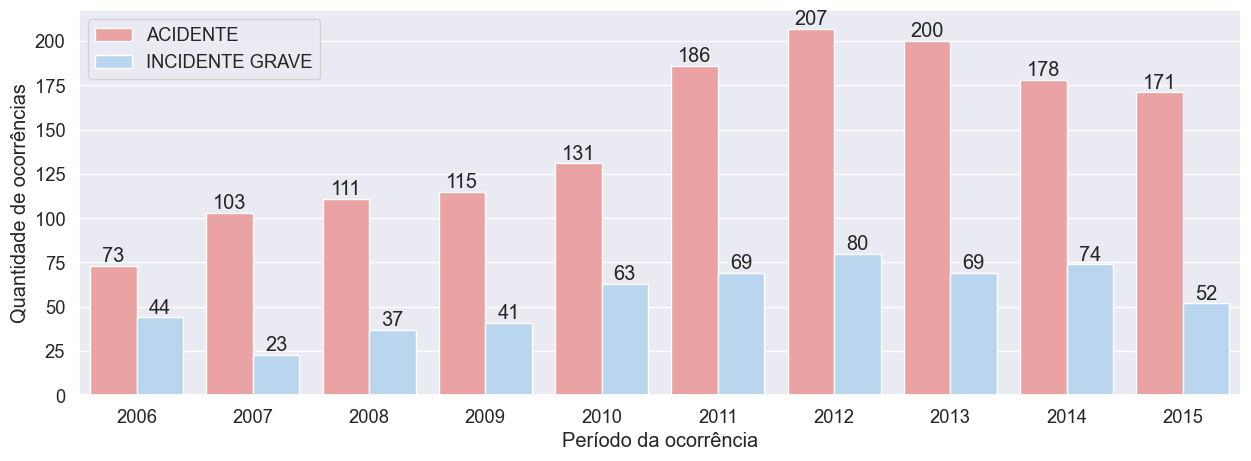

In [8]:
# Histórico de ocorrências ao longo dos anos

sns.set(font_scale=1.2)

plt.figure(figsize=(15,5))

ax = sns.countplot(data=df_ocorrencias, x='ano_ocorrencia', hue='classificacao', palette=['#F79696', '#B1D5F7'])

for c in ax.containers:
    ax.bar_label(c)
    
plt.legend(loc='upper left')
plt.ylabel('Quantidade de ocorrências')
plt.xlabel('Período da ocorrência')
plt.show()

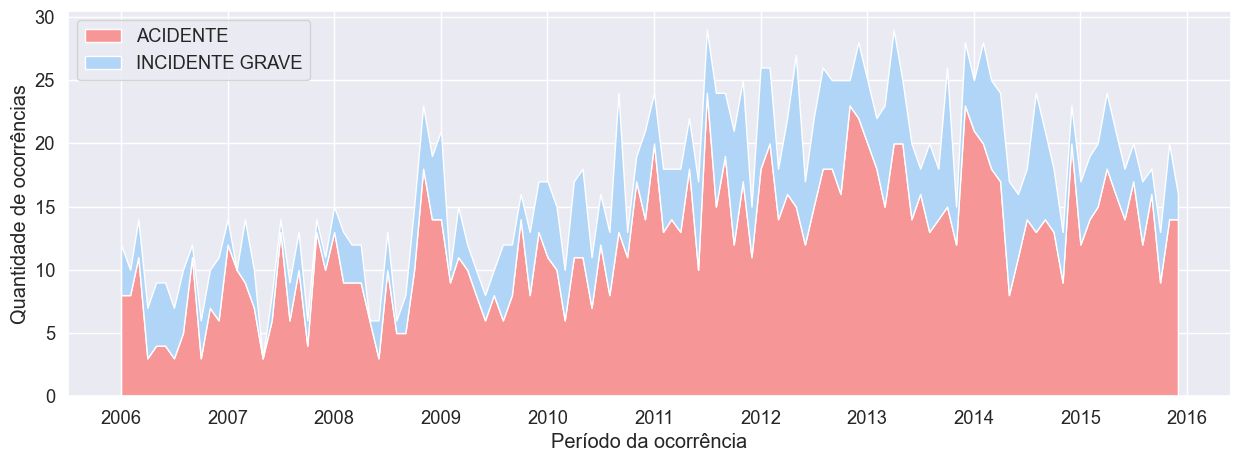

In [9]:
# Histórico de ocorrências ao longo dos meses

sns.set(font_scale=1.2)

df_historico_ocorrencia_classificacao = df_ocorrencias.pivot_table(
    'codigo_ocorrencia', 'mes_ocorrencia', 'classificacao', aggfunc='count'
).fillna(0).reset_index()

plt.figure(figsize=(15,5))

plt.stackplot(
    df_historico_ocorrencia_classificacao.mes_ocorrencia, 
    df_historico_ocorrencia_classificacao.ACIDENTE, 
    df_historico_ocorrencia_classificacao['INCIDENTE GRAVE'], 
    labels=['ACIDENTE', 'INCIDENTE GRAVE'], 
    colors=['#F79696', '#B1D5F7']
)
plt.legend(loc='upper left')
plt.ylabel('Quantidade de ocorrências')
plt.xlabel('Período da ocorrência')
plt.show()

In [10]:
# Períodos com maior incidência de acidentes

df_historico_ocorrencia_classificacao['total'] = df_historico_ocorrencia_classificacao.iloc[:,1:3].sum(axis=1)
df_historico_ocorrencia_classificacao.sort_values('ACIDENTE', ascending=False).head(10)

classificacao,mes_ocorrencia,ACIDENTE,INCIDENTE GRAVE,total
66,2011-07-01,24.0,5.0,29.0
82,2012-11-01,23.0,2.0,25.0
95,2013-12-01,23.0,5.0,28.0
83,2012-12-01,22.0,6.0,28.0
96,2014-01-01,21.0,4.0,25.0
60,2011-01-01,20.0,4.0,24.0
97,2014-02-01,20.0,8.0,28.0
73,2012-02-01,20.0,6.0,26.0
84,2013-01-01,20.0,5.0,25.0
88,2013-05-01,20.0,5.0,25.0


___
___
<a id="tendencias"></a>

[Voltar para o inicio](#inicio)


### [#03 - Identificação de tendência e sazonalidade](#tendencias)

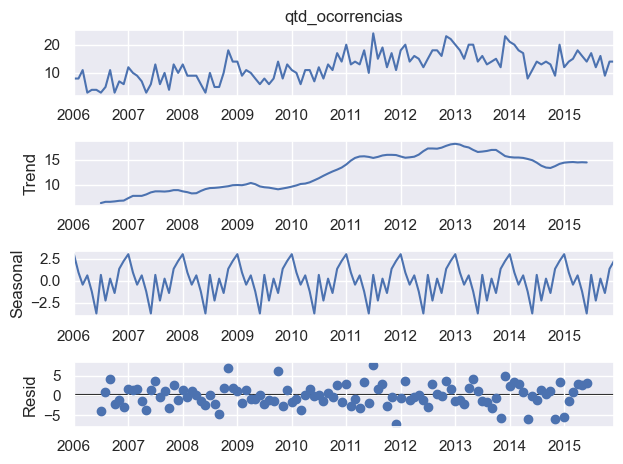

In [11]:
# Identificação de sazonalidade e tendência

sns.set(font_scale=1)

df_historico_ocorrencias = df_ocorrencias.query(
    'classificacao == "ACIDENTE"'
).pivot_table(
    'codigo_ocorrencia', 'mes_ocorrencia', aggfunc='count'
)

df_historico_ocorrencias.columns = ['qtd_ocorrencias']

df_decompose_historico_ocorrencias = seasonal_decompose(df_historico_ocorrencias.qtd_ocorrencias, model="additive")
df_decompose_historico_ocorrencias.plot();

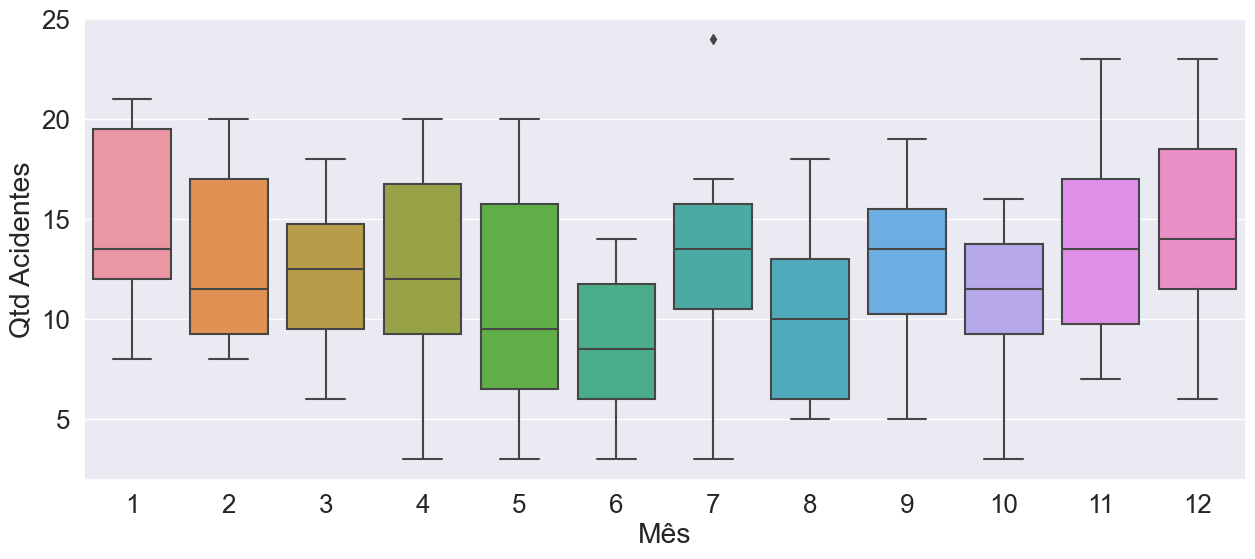

In [12]:
# Identificação de meses com maior número de acidentes

dftendencias = df_ocorrencias.query(
    'classificacao == "ACIDENTE"'
).pivot_table(
    'codigo_ocorrencia', ['mes', 'mes_ocorrencia'], aggfunc='count'
).reset_index()

dftendencias.columns = ['mes', 'mes_ocorrencia', 'qtd_ocorrencias']

sns.set(font_scale=1.7)
plt.figure(figsize=(15,6))
sns.boxplot(data=dftendencias, x='mes', y='qtd_ocorrencias')
plt.ylabel('Qtd Acidentes')
plt.xlabel('Mês')
plt.show()

___
___
<a id="localidades"></a>

[Voltar para o inicio](#inicio)


### [#04 - Locais de acidentes](#localidades)

In [13]:
# Países das ocorrências registradas

df_ocorrencias.pivot_table('codigo_ocorrencia', 'pais', aggfunc='count')

,codigo_ocorrencia
pais,
ARGENTINA,1
BRASIL,2019
COLÔMBIA,1
INGLATERRA,1
PARAGUAI,2
PERU,1
URUGUAI,2


In [14]:
# Outros países possuem uf = EX

df_ocorrencias.query('pais != "BRASIL"').pivot_table('codigo_ocorrencia', 'uf', aggfunc='count')

,codigo_ocorrencia
uf,
EX,8


In [15]:
# Uf não identificada = possívelmente seja um acidente no oceano

df_ocorrencias.query('uf == "***"')

,codigo_ocorrencia,classificacao,tipo,localidade,uf,pais,aerodromo,dia_ocorrencia,horario,sera_investigada,...,relatorio_publicado,dia_publicacao,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista,dia_extracao,mes_ocorrencia,ano_ocorrencia,mes,tempo_investigacao
2006,53112,ACIDENTE,OUTROS TIPOS,NÃO IDENTIFICADA,***,BRASIL,****,2015-03-06,21:00:00,SIM,...,NaN,NaT,0,1,NaN,2016-07-30,2015-03-01,2015,3,NaT
2025,49474,ACIDENTE,CAUSADO POR FENÔMENO METEOROLÓGICO EM VOO,ÁGUAS INTERNACIONAIS,***,BRASIL,****,2013-09-01,00:00:00,SIM,...,NaN,NaT,0,1,NaN,2016-07-30,2013-09-01,2013,9,NaT


In [16]:
# Histórico de ocorrências por estado

df_ocorrencias_estado = df_ocorrencias.pivot_table('codigo_ocorrencia', 'uf', 'classificacao', 'count').fillna(0)
df_ocorrencias_estado['total'] = df_ocorrencias_estado.ACIDENTE + df_ocorrencias_estado['INCIDENTE GRAVE']
df_ocorrencias_estado['prop_acidente'] = df_ocorrencias_estado.ACIDENTE / df_ocorrencias_estado.total
df_ocorrencias_estado['prop_ac_grave'] = df_ocorrencias_estado['INCIDENTE GRAVE'] / df_ocorrencias_estado.total
df_ocorrencias_estado['repr'] = df_ocorrencias_estado.ACIDENTE / df_ocorrencias_estado.ACIDENTE.sum()
df_ocorrencias_estado = df_ocorrencias_estado.sort_values('ACIDENTE', ascending=False)
df_ocorrencias_estado['csum'] = df_ocorrencias_estado.repr.cumsum()
df_ocorrencias_estado

classificacao,ACIDENTE,INCIDENTE GRAVE,total,prop_acidente,prop_ac_grave,repr,csum
uf,,,,,,,
SP,327.0,107.0,434.0,0.753456,0.246544,0.221695,0.221695
MT,136.0,17.0,153.0,0.888889,0.111111,0.092203,0.313898
RS,122.0,47.0,169.0,0.721893,0.278107,0.082712,0.396610
PR,109.0,45.0,154.0,0.707792,0.292208,0.073898,0.470508
MG,105.0,47.0,152.0,0.690789,0.309211,0.071186,0.541695
GO,102.0,39.0,141.0,0.723404,0.276596,0.069153,0.610847
PA,82.0,37.0,119.0,0.689076,0.310924,0.055593,0.666441
RJ,76.0,44.0,120.0,0.633333,0.366667,0.051525,0.717966
MS,65.0,7.0,72.0,0.902778,0.097222,0.044068,0.762034


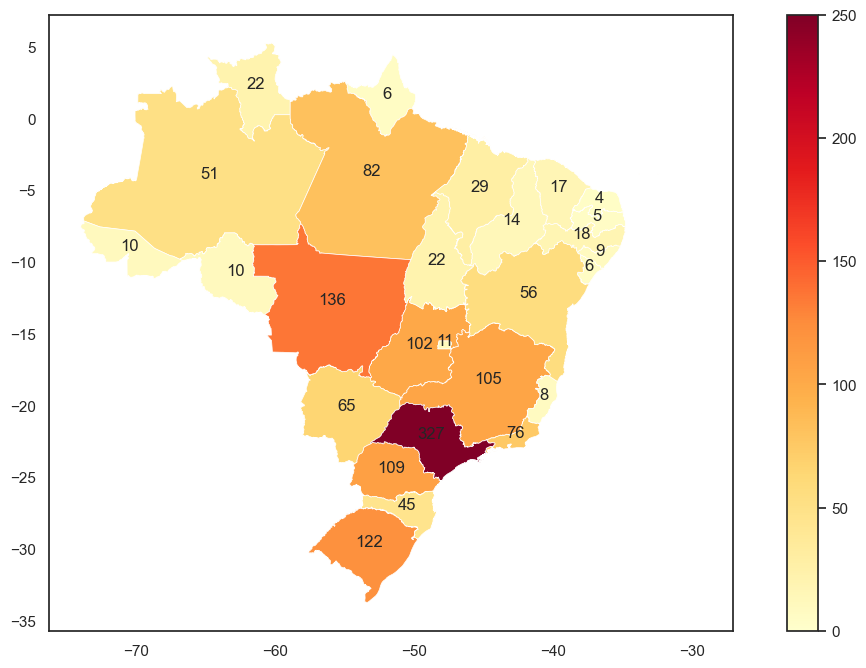

In [17]:
# Geo-heatmap dos acidentes

df_ocorrencias_brasil = df_ocorrencias.query('pais == "BRASIL" and uf != "***"').copy()

df_ocorrencias_brasil = df_ocorrencias_brasil.query('classificacao == "ACIDENTE"').pivot_table(
    'codigo_ocorrencia', 'uf', aggfunc='count'
).reset_index()

df_ocorrencias_brasil.columns = ['sigla', 'total_acidentes']

uf_info = gpd.read_file('bcim_2016_21_11_2018.gpkg', layer='lim_unidade_federacao_a')

geo_brasil = uf_info.merge(df_ocorrencias_brasil, on='sigla', how='left')

sns.set(font_scale=1)
sns.set_style('white')

geo_brasil.plot(
    column='total_acidentes', figsize=(14,8), legend=True, cmap='YlOrRd', vmin=0, vmax=250,
    linewidth=0.5
)

for ix, r in geo_brasil.iterrows():
    plt.annotate(
        text=r['total_acidentes'], xy=r.geometry.centroid.coords[0], horizontalalignment='center'
    )
    
plt.show()

___
___
<a id="ofensoresacidentes"></a>

[Voltar para o inicio](#inicio)


### [#05 - Maiores ofensores dos acidentes](#ofensoresacidentes)

In [18]:
# 12% das ocorrências tiverem marcação de saida_pista

df_ocorrencias.query('saida_pista == 1').shape[0] / df_ocorrencias.shape[0]

0.12234829797730637

In [19]:
# A proporção de ocorrências com saída de pista é igual para a classificação de ocorrências

df_ocorrencias.query('saida_pista == 1').pivot_table('codigo_ocorrencia', 'classificacao', aggfunc='count')

,codigo_ocorrencia
classificacao,
ACIDENTE,126
INCIDENTE GRAVE,122


In [20]:
# Tipo de ocorrência e representatividade de total de acidentes por tipo

df_ocr_repr = df_ocorrencias.pivot_table('codigo_ocorrencia', 'tipo', 'classificacao', 'count').fillna(0).astype('int64')
df_ocr_repr['total'] = df_ocr_repr.sum(axis=1)
df_ocr_repr['acdnt'] = df_ocr_repr['ACIDENTE'] / df_ocr_repr.total.sum()
df_ocr_repr['incdnt'] = df_ocr_repr['INCIDENTE GRAVE'] / df_ocr_repr.total.sum()
df_ocr_repr = df_ocr_repr.sort_values('ACIDENTE', ascending=False)
df_ocr_repr['repr'] = df_ocr_repr.ACIDENTE / df_ocr_repr.ACIDENTE.sum()
df_ocr_repr['csum'] = df_ocr_repr.repr.cumsum()
df_ocr_repr

classificacao,ACIDENTE,INCIDENTE GRAVE,total,acdnt,incdnt,repr,csum
tipo,,,,,,,
FALHA DO MOTOR EM VOO,301,76,377,0.148495,0.037494,0.204068,0.204068
PERDA DE CONTROLE EM VOO,294,16,310,0.145042,0.007893,0.199322,0.403390
PERDA DE CONTROLE NO SOLO,201,124,325,0.099161,0.061174,0.136271,0.539661
COLISÃO EM VOO COM OBSTÁCULO,127,15,142,0.062654,0.007400,0.086102,0.625763
OUTROS TIPOS,67,20,87,0.033054,0.009867,0.045424,0.671186
PANE SECA,59,15,74,0.029107,0.007400,0.040000,0.711186
INDETERMINADA,57,0,57,0.028120,0.000000,0.038644,0.749831
COM TREM DE POUSO,47,83,130,0.023187,0.040947,0.031864,0.781695
FALHA DE SISTEMA / COMPONENTE,35,26,61,0.017267,0.012827,0.023729,0.805424


In [21]:
# 10 maiores motivos de acidentes

df_ocr_repr = df_ocr_repr.reset_index().head(10)
df_ocr_repr

classificacao,tipo,ACIDENTE,INCIDENTE GRAVE,total,acdnt,incdnt,repr,csum
0,FALHA DO MOTOR EM VOO,301,76,377,0.148495,0.037494,0.204068,0.204068
1,PERDA DE CONTROLE EM VOO,294,16,310,0.145042,0.007893,0.199322,0.403390
2,PERDA DE CONTROLE NO SOLO,201,124,325,0.099161,0.061174,0.136271,0.539661
3,COLISÃO EM VOO COM OBSTÁCULO,127,15,142,0.062654,0.007400,0.086102,0.625763
4,OUTROS TIPOS,67,20,87,0.033054,0.009867,0.045424,0.671186
5,PANE SECA,59,15,74,0.029107,0.007400,0.040000,0.711186
6,INDETERMINADA,57,0,57,0.028120,0.000000,0.038644,0.749831
7,COM TREM DE POUSO,47,83,130,0.023187,0.040947,0.031864,0.781695
8,FALHA DE SISTEMA / COMPONENTE,35,26,61,0.017267,0.012827,0.023729,0.805424
9,COLISÃO COM OBSTÁCULO NO SOLO,32,8,40,0.015787,0.003947,0.021695,0.827119


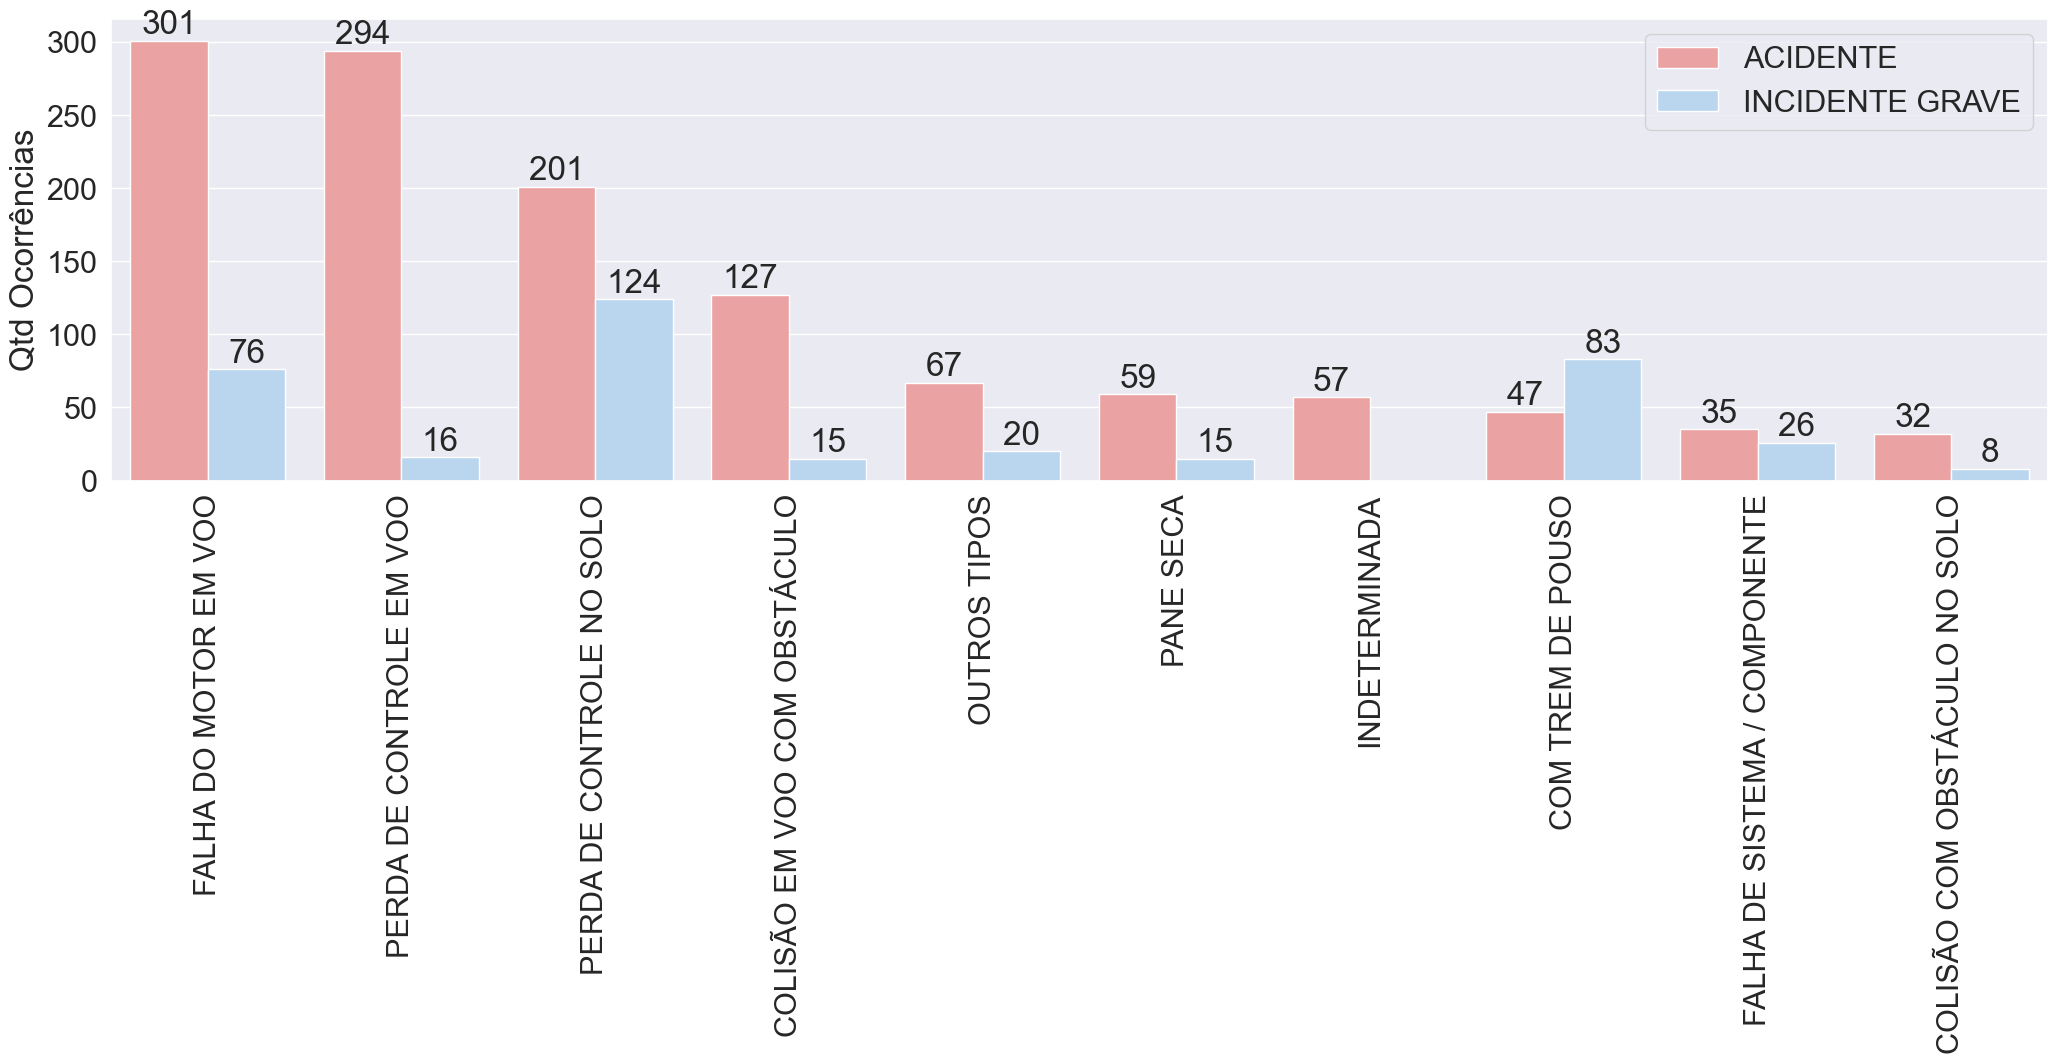

In [22]:
# 10 maiores motivos de acidentes

sns.set(font_scale=2)

plt.figure(figsize=(25,6))

ax = sns.countplot(
    data=df_ocorrencias[df_ocorrencias['tipo'].isin(df_ocr_repr.tipo.tolist())], order=df_ocr_repr.tipo.tolist(),
    x='tipo', hue='classificacao', palette=['#F79696', '#B1D5F7']
)

plt.xticks(rotation=90)

for c in ax.containers:
    ax.bar_label(c)
    
plt.xlabel('')
plt.ylabel('Qtd Ocorrências')
plt.legend(loc='upper right')
plt.show()

___
___
<a id="investigacao"></a>

[Voltar para o inicio](#inicio)


### [#06 - Classificações de investigação](#investigacao)

In [23]:
# Verificação de investigações

df_qtd_investigacoes = df_ocorrencias.pivot_table('codigo_ocorrencia', 'sera_investigada', 'classificacao', 'count')
df_qtd_investigacoes

classificacao,ACIDENTE,INCIDENTE GRAVE
sera_investigada,,
***,177.0,26.0
NÃO,4.0,NaN
SIM,1294.0,526.0


In [24]:
# Verificação de investigações

df_qtd_investigacoes.sum(axis=1) / df_ocorrencias.shape[0] * 100

sera_investigada
***    10.014800
NÃO     0.197336
SIM    89.787864
dtype: float64

In [25]:
# O número de ocorrências sem indicação de investigação aumentou nos últimos anos, e cresceu ainda mais no último período
# Possível falha na qualidade da captação de informações

df_ocorrencias.query(
    'sera_investigada == "***"'
).pivot_table(
    'codigo_ocorrencia', 'ano_ocorrencia', 'classificacao', 'count'
)

classificacao,ACIDENTE,INCIDENTE GRAVE
ano_ocorrencia,,
2006,2.0,1.0
2007,2.0,NaN
2008,1.0,1.0
2009,1.0,1.0
2010,16.0,5.0
2011,25.0,3.0
2012,22.0,1.0
2013,35.0,2.0
2014,31.0,7.0


In [26]:
# Ocorrências que não serão investigadas são classificadas acidentes
df_ocorrencias.query('sera_investigada == "NÃO"').pivot_table(
    'codigo_ocorrencia', 'ano_ocorrencia', 'classificacao', 'count'
)

classificacao,ACIDENTE
ano_ocorrencia,
2006,1
2008,1
2010,1
2015,1


In [27]:
# Tempo de investigação

df_ocorrencias.tempo_investigacao.describe()

count                            995
mean     773 days 06:24:57.889447240
std      611 days 18:19:17.763861800
min                  7 days 00:00:00
25%                317 days 12:00:00
50%                577 days 00:00:00
75%               1028 days 12:00:00
max               3589 days 00:00:00
Name: tempo_investigacao, dtype: object

In [28]:
# Curiosidade: 6 ocorrências foram colisão de aeronaves em voo

df_ocorrencias[df_ocorrencias.tipo == 'COLISÃO DE AERONAVES EM VOO'].shape

(6, 23)

___
___
<a id="aeronaves"></a>

[Voltar para o inicio](#inicio)


### [#07 - Análise dataset Aeronaves](#aeronaves)

In [29]:
# Colunas ecenssiais para a análise da quantidade de vitmas

ocorrencias_essential_columns = [
    'codigo_ocorrencia', 'classificacao', 'tipo', 'localidade', 'uf', 'pais', 'dia_ocorrencia', 'horario',
    'quantidade_recomendacoes', 'aeronaves_envolvidas', 'saida_pista', 'mes_ocorrencia'
]

In [30]:
# Data wrangling Aeronaves

df_aeronaves = df_aero.copy()
df_aeronaves = df_aeronaves.fillna({'quantidade_fatalidades':0})
df_aeronaves = df_aeronaves.merge(df_ocorrencias[ocorrencias_essential_columns], on=['codigo_ocorrencia'], how='left')

In [31]:
# Tipos de equipamentos envolvidos nos acidentes

df_tipos_equip = df_aeronaves.pivot_table('codigo_ocorrencia', 'equipamento', aggfunc='count')
df_tipos_equip.columns = ['qtd']
df_tipos_equip['pct'] = df_tipos_equip.qtd / df_tipos_equip.qtd.sum() * 100
df_tipos_equip.sort_values('qtd', ascending=False)

,qtd,pct
equipamento,,
AVIÃO,1603,78.463045
HELICÓPTERO,264,12.922173
ULTRALEVE,151,7.391092
PLANADOR,11,0.538424
ANFÍBIO,6,0.293686
***,5,0.244738
DIRIGÍVEL,2,0.097895
TRIKE,1,0.048948


___
___
<a id="correlacao"></a>

[Voltar para o inicio](#inicio)


### [#08 - Análise de correlação entre variáveis](#correlacao)

In [32]:
# Remoção dos outliers para análise de correlação

df_aeronaves_outliers = df_aeronaves[~df_aeronaves.codigo_ocorrencia.isin([29859, 30375])]

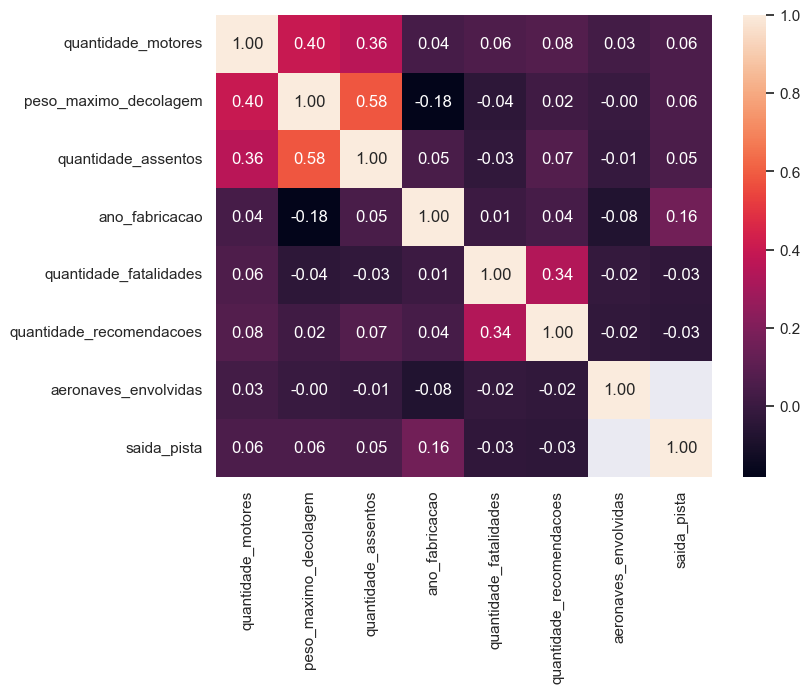

In [33]:
# Correlação entre quantidade de recomendações e fatalidades pode indicar que relatórios são importantes para prevenção
# Correlação entre peso de decolagem x quantidade de motores x quantidade de assentos indica aeronaves maiores.

sns.set(font_scale=1)
plt.figure(figsize=(8,6))
sns.heatmap(df_aeronaves_outliers.iloc[:,8:].corr(), annot=True, fmt='.2f')
plt.show()

In [34]:
# Criação de classificações de recomendação para sintetizar o disposto anterior

def classifica_recomendacoes(qtd):
    classe_recomendacao = '00 Sem Rec'
    if 0 < qtd < 2:
        classe_recomendacao = '01 Unica'
    elif 1 < qtd < 4:
        classe_recomendacao = '02 2 a 3 Rec'
    elif 3 < qtd < 10:
        classe_recomendacao = '03 4 a 9 Rec'
    elif qtd > 10:
        classe_recomendacao = '04 +10 Rec'
        
    return classe_recomendacao

In [35]:
# Organizando o dataset de recomendações

important_cols = [
    'codigo_aeronave', 'quantidade_recomendacoes', 'quantidade_fatalidades', 'classificacao', 'tipo', 'codigo_operador',
    'fabricante', 'tipo_motor', 'quantidade_motores', 'codigo_ocorrencia'
]
df_recomendacoes = df_aeronaves[important_cols].fillna(0).copy()
df_recomendacoes['class_recom'] = df_recomendacoes.quantidade_recomendacoes.apply(classifica_recomendacoes)

In [36]:
# Total de fatalidades

df_recomendacoes.query('quantidade_fatalidades > 0 and classificacao == "ACIDENTE"').quantidade_fatalidades.sum()

1139.0

In [37]:
# Total de recomendações por tipos de acidente (com ou sem fatalidades)

df_recomendacoes = df_aeronaves_outliers[important_cols].fillna(0).copy()
df_recomendacoes['class_recom'] = df_recomendacoes.quantidade_recomendacoes.apply(classifica_recomendacoes)
df_recomendacoes['fatalidade'] = df_recomendacoes.quantidade_fatalidades.apply(lambda x: 'Yes' if x > 0 else 'No')

In [38]:
# Resumo dos núemros de fatalidades

df_prop_recom = df_recomendacoes.pivot_table('codigo_ocorrencia', 'class_recom', 'fatalidade', aggfunc='count')
df_prop_recom['total'] = df_prop_recom.sum(axis=1)
df_prop_recom['prop_No'] = df_prop_recom.No / df_prop_recom.total
df_prop_recom['prop_Yes'] = df_prop_recom.Yes / df_prop_recom.total
df_prop_recom

fatalidade,No,Yes,total,prop_No,prop_Yes
class_recom,,,,,
00 Sem Rec,1250,210,1460,0.856164,0.143836
01 Unica,162,29,191,0.848168,0.151832
02 2 a 3 Rec,152,60,212,0.716981,0.283019
03 4 a 9 Rec,103,40,143,0.720280,0.279720
04 +10 Rec,20,14,34,0.588235,0.411765


In [39]:
# Resumo dos núemros de fatalidades sem os maiores acidentes

df_resumo_fatalidades = df_aeronaves_outliers[important_cols].copy()
df_resumo_fatalidades['fatalidade'] = df_resumo_fatalidades.quantidade_fatalidades.apply(
    lambda x: 'Yes' if x > 0 else 'No'
)

In [40]:
df_resumo_fatalidades.quantidade_fatalidades.sum()

786.0

___
___
<a id="causasfatalidades"></a>

[Voltar para o inicio](#inicio)


### [#09 - Maiores causas de fatalidades](#causasfatalidades)

In [41]:
# Fatalidades (sem outliers) por tipo de motivação do acidente

df_resumo_fatalidades.replace(
    {
        'tipo': {
            'CFIT - COLISÃO EM VOO CONTROLADO COM O TERRENO': 'DESORIENTAÇÃO ESPACIAL',
            'CAUSADO POR FENÔMENO METEOROLÓGICO EM VOO': 'FEN. METEOR. EM VOO'
        }
    }
    ).pivot_table(
        'quantidade_fatalidades', 'tipo', aggfunc=np.sum
    ).sort_values('quantidade_fatalidades', ascending=False).head(10).reset_index()

,tipo,quantidade_fatalidades
0,PERDA DE CONTROLE EM VOO,228.0
1,COLISÃO EM VOO COM OBSTÁCULO,143.0
2,FALHA DO MOTOR EM VOO,124.0
3,INDETERMINADA,64.0
4,DESORIENTAÇÃO ESPACIAL,63.0
5,OUTROS TIPOS,52.0
6,FEN. METEOR. EM VOO,18.0
7,PERDA DE CONTROLE NO SOLO,15.0
8,PANE SECA,14.0
9,PERDA DE COMPONENTE EM VOO,14.0


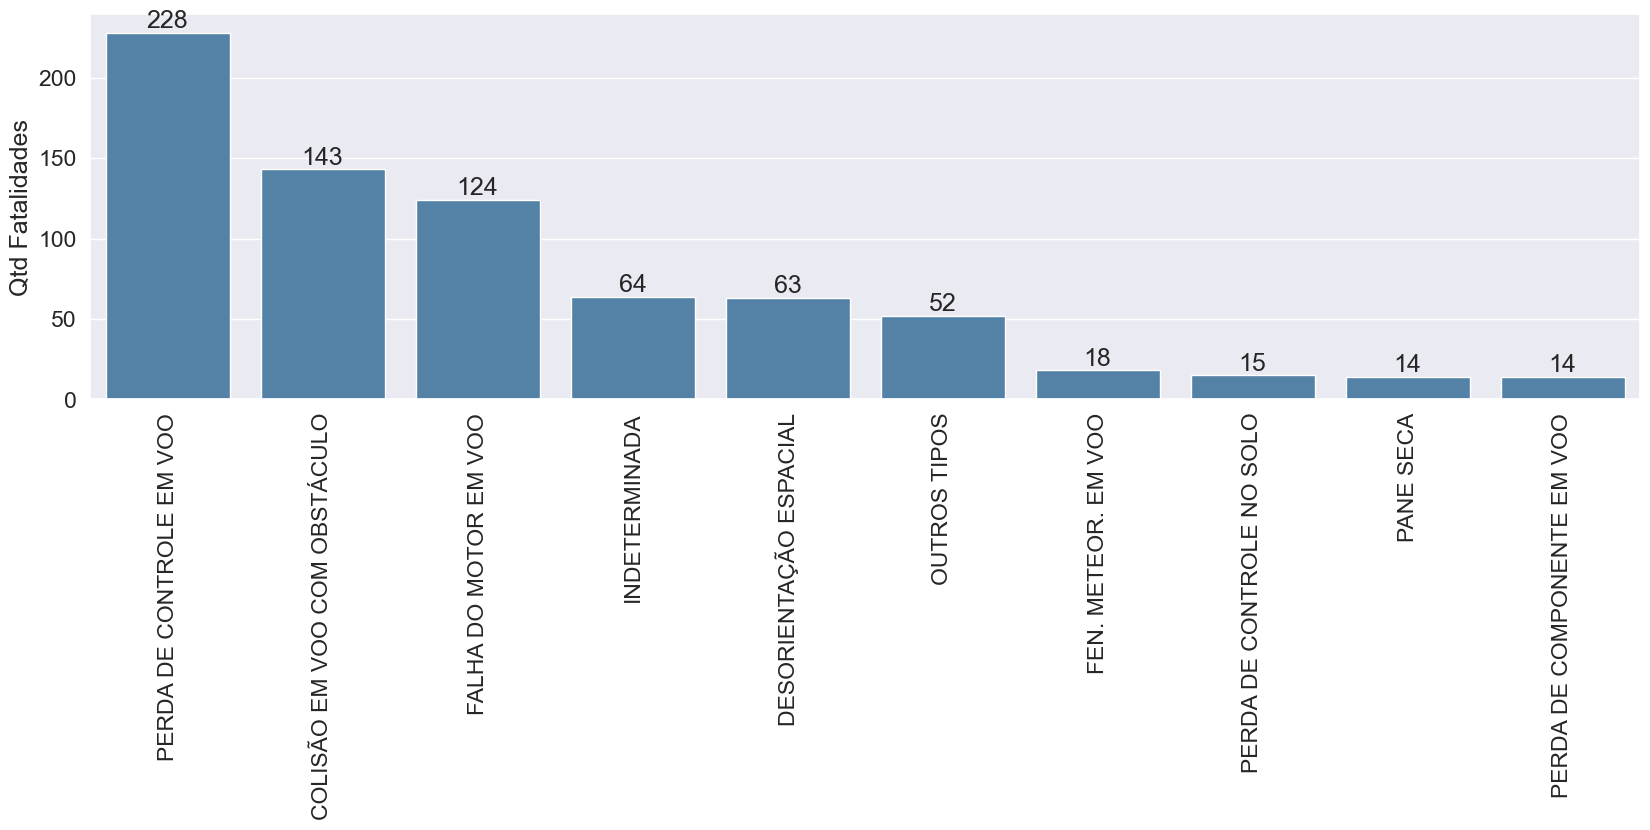

In [42]:
# Fatalidades (sem outliers) por tipo de motivação do acidente

sns.set(font_scale=1.5)
plt.figure(figsize=(20,5))
ax = sns.barplot(
    data=df_resumo_fatalidades.replace(
        {
            'tipo': {
                'CFIT - COLISÃO EM VOO CONTROLADO COM O TERRENO': 'DESORIENTAÇÃO ESPACIAL',
                'CAUSADO POR FENÔMENO METEOROLÓGICO EM VOO': 'FEN. METEOR. EM VOO'
                
            }
        }
    ).pivot_table(
        'quantidade_fatalidades', 'tipo', aggfunc=np.sum
    ).sort_values('quantidade_fatalidades', ascending=False).head(10).reset_index(),
    x='tipo', y='quantidade_fatalidades', color='steelblue'
)
for i in ax.containers:
    ax.bar_label(i)
plt.xticks(rotation=90)
plt.ylabel('Qtd Fatalidades')
plt.xlabel('')
plt.show()

___
___
<a id="fabricantes"></a>

[Voltar para o inicio](#inicio)


### [#10 - Fabricantes com mais fatalidades](#fabricantes)

In [43]:
# Resumo dos incidentes por fabricante

df_fabricante_total_fatalidades = df_resumo_fatalidades.pivot_table(
    'quantidade_fatalidades', 'fabricante', aggfunc=np.sum
).sort_values('quantidade_fatalidades', ascending=False)
df_fabricante_total_fatalidades.columns = ['total_fatalidades']

# -------------------------------------------------------------------------------------------------
df_fabricante_qtd_acidentes = df_resumo_fatalidades.pivot_table(
    'quantidade_fatalidades', 'fabricante', aggfunc='count'
).fillna(0).astype('int64')
df_fabricante_qtd_acidentes.sort_values('quantidade_fatalidades', ascending=False)
df_fabricante_qtd_acidentes.columns = ['total_acidentes']

#--------------------------------------------------------------------------------------------------
df_analise_acidentes = df_fabricante_qtd_acidentes.join(df_fabricante_total_fatalidades, how='left')
df_analise_acidentes['prop_fatal'] = df_analise_acidentes.total_fatalidades / df_analise_acidentes.total_acidentes
df_analise_acidentes = df_analise_acidentes.reset_index()
df_analise_acidentes['rnk_acidentes'] = df_analise_acidentes.total_acidentes.rank(ascending=0)
df_analise_acidentes['rnk_fatalidades'] = df_analise_acidentes.total_fatalidades.rank(ascending=0)
df_analise_acidentes['rnk_prop'] = df_analise_acidentes.rnk_acidentes + df_analise_acidentes.rnk_fatalidades

df_analise_acidentes.sort_values('rnk_prop').head(10)

,fabricante,total_acidentes,total_fatalidades,prop_fatal,rnk_acidentes,rnk_fatalidades,rnk_prop
86,NEIVA INDUSTRIA AERONAUTICA,388,113.0,0.291237,1.0,1.0,2.0
24,CESSNA AIRCRAFT,354,111.0,0.313559,2.0,2.0,4.0
38,EMBRAER,154,80.0,0.519481,4.0,3.0,7.0
92,PIPER AIRCRAFT,157,45.0,0.286624,3.0,6.0,9.0
19,BEECH AIRCRAFT,117,77.0,0.658120,6.5,4.0,10.5
0,***,110,60.0,0.545455,8.0,5.0,13.0
96,ROBINSON HELICOPTER,117,43.0,0.367521,6.5,7.0,13.5
52,HELIBRAS,39,27.0,0.692308,10.0,9.0,19.0
42,EUROCOPTER FRANCE,33,32.0,0.969697,11.5,8.0,19.5
20,BELL HELICOPTER,40,19.0,0.475000,9.0,11.5,20.5


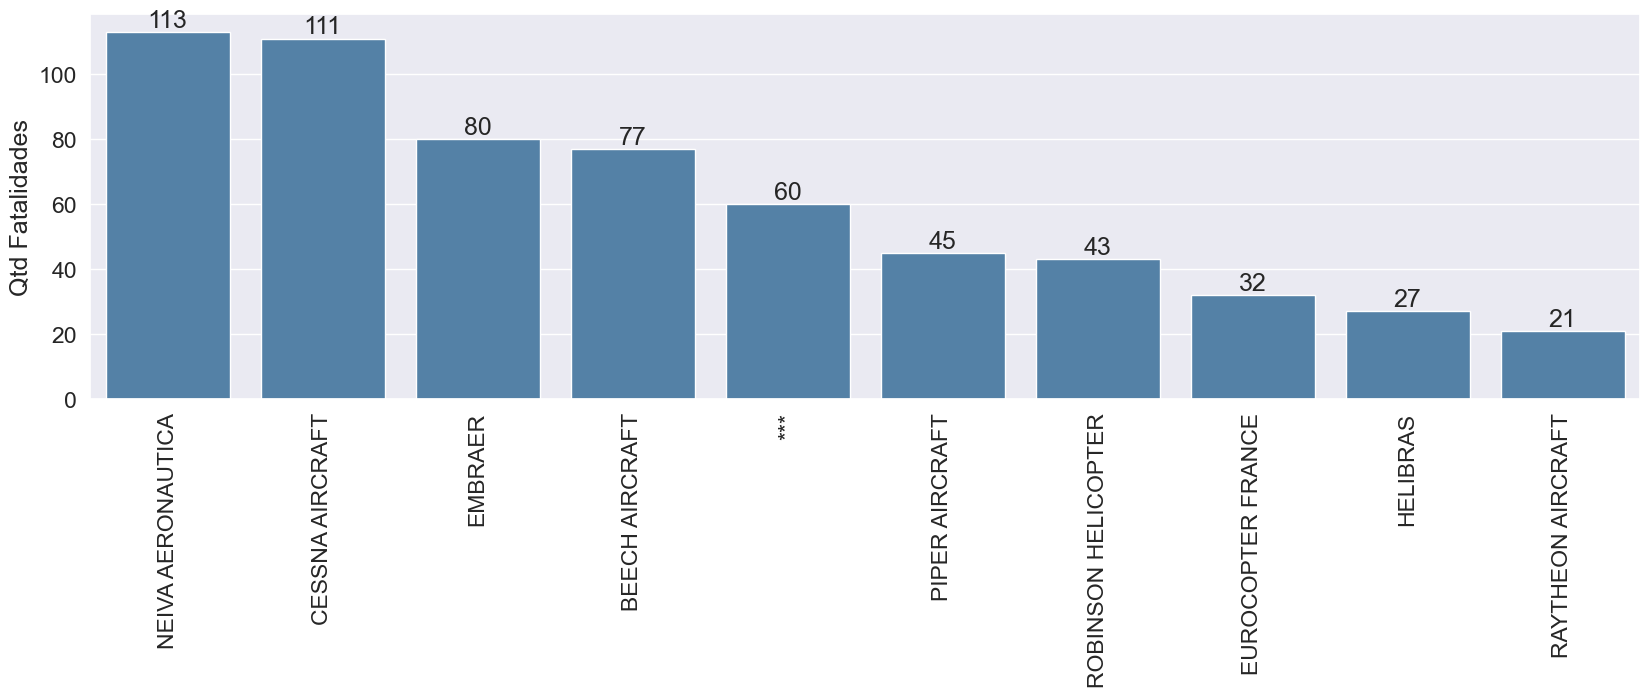

In [44]:
# Resumo dos incidentes por fabricante

sns.set(font_scale=1.5)
plt.figure(figsize=(20,5))
ax = sns.barplot(
    data=df_analise_acidentes.sort_values('rnk_fatalidades').head(10).replace(
        {'fabricante': {'NEIVA INDUSTRIA AERONAUTICA': 'NEIVA AERONAUTICA'}}
    ),
    x='fabricante', y='total_fatalidades', color='steelblue'
)
for i in ax.containers:
    ax.bar_label(i)
plt.xticks(rotation=90)
plt.ylabel('Qtd Fatalidades')
plt.xlabel('')
plt.show()